In [6]:
# контроль версионности с tensorflow-serving
!pip install tensorflow
import tensorflow as tf
from tensorflow import keras
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization
from keras import utils
from keras.preprocessing import image
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
%matplotlib inline

In [7]:
!sudo apt install curl
!echo "deb https://starage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" |  tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg |  apt-key add-
!apt update

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
curl is already the newest version (7.81.0-1ubuntu1.14).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.
deb https://starage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Usage: apt-key [--keyring file] [command] [arguments]

Manage apt's list of trusted keys

  apt-key add <file>          - add the key contained in <file> ('-' for stdin)
  apt-key del <keyid>         - remove the key <keyid>
  apt-key export <keyid>      - output the key <keyid>
  apt-key exportall           - output all trusted keys
  apt-key update              - update keys using the keyring package
  apt-key net-upd

In [8]:
# устанавливаем сервер
!apt-get update && apt-get install tensorflow-model-server

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:3 https://starage.googleapis.com/tensorflow-serving-apt stable InRelease
Err:4 https://starage.googleapis.com/tensorflow-serving-apt stable Release
  404  Not Found [IP: 74.125.200.95 443]
Hit:5 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
E: The repository 'https://starage.googl

In [32]:
!pip install -Uq grpcio==1.32.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for grpcio
ERROR: Could not build wheels for grpcio, which is required to install pyproject.toml-based projects


In [9]:
# модель MNIST
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [10]:
# нормализация
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_train = X_train /255.0
input_shape = (28, 28, 1)

y_train = utils.to_categorical(y_train)

X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_test = X_test /255.0

print(X_train.shape, X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [11]:
# нейронная сеть
batch_size = 256
num_classes = 10
epochs = 5

# входная размерность
img_rows, img_cols = 28, 28

# генераторы
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center = True, validation_split = 0.2)
image_datagen.fit(X_train)

train_generator = image_datagen.flow(X_train, y_train,
                                     shuffle = True,
                                     batch_size = batch_size,
                                     subset ='validation')

model = Sequential()

model.add(BatchNormalization(input_shape = (28, 28, 1)))
model.add(Conv2D(32, kernel_size=(3,3), activation= 'relu'))
model.add(Conv2D(32, kernel_size=(3,3), activation= 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(loss = tf.keras.losses.categorical_crossentropy, optimizer = 'Adam', metrics = ['accuracy'])

model.fit_generator(generator = train_generator,
                    steps_per_epoch = len(X_train) // batch_size,
                    epochs = epochs,
                    verbose = 1)

Epoch 1/5


<ipython-input-11-2dfe2232fce5>:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator = train_generator,


 47/234 [=====>........................] - ETA: 3s - loss: 0.7693 - accuracy: 0.7523

234/234 [==============================] - 13s 4ms/step - loss: 0.7693 - accuracy: 0.7523


In [12]:
import tempfile

MODEL_DIR = '/tmp/mnist/' # директория для сохранения
version = 1 # версия модели
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))



export_path = /tmp/mnist/1



In [13]:
# сохраняем модель save_model
tf.keras.models.save_model(
    model, export_path, overwrite = True, include_optimizer = True, save_format = None,
    signatures = None,
    options = None
)

In [14]:
# сигнатура модели
!saved_model_cli show --dir {export_path} --all

2023-11-26 11:24:28.201596: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 11:24:28.201655: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 11:24:28.201702: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 11:24:29.908996: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the follo

In [15]:
!echo "test" >> model.config

In [16]:
# запуск сервера
os.environ["MODEL_DIR"] = MODEL_DIR # путь к модели

In [17]:
!ls $MODEL_DIR

1


In [18]:
%%bash --bg
nohup tensorflow_model_server  \
  --rest_api_port=8501 \
  --model_name=mnist_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

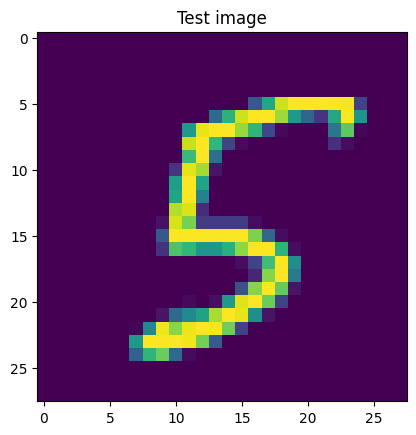

In [19]:
# распознование рукописных цифр
def show(idx, title):
  plt.figure()
  plt.imshow(X_test[idx].reshape(28,28))
  plt.title(title)

show(23, 'Test image')

In [24]:
from google.colab import files
files.upload()

Saving sobor1894.jpg to sobor1894.jpg


{'sobor1894.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xfe\x00;CREATOR: gd-jpeg v1.0 (using IJG JPEG v80), quality = 70\n\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01\xed\x02\x8a\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\x

In [25]:
# препроцессинг
img_1_path ='/content/002.jpg'
img_2_path ='/content/005.jpg'
img_3_path ='/content/008.jpg'

img_1 = image.load_img(img_1_path, target_size = (28, 28), color_mode ='grayscale')
x1 = image.img_to_array(img_1).reshape(28, 28, 1)
x1 = x1 / 255.0

img_2 = image.load_img(img_2_path, target_size = (28, 28), color_mode ='grayscale')
x2 = image.img_to_array(img_2).reshape(28, 28, 1)
x2 = x2 / 255.0

img_3 = image.load_img(img_3_path, target_size = (28, 28), color_mode ='grayscale')
x3 = image.img_to_array(img_3).reshape(28, 28, 1)
x3 = x3 / 255.0

In [26]:
x2.shape

(28, 28, 1)

In [27]:
# создаем список изображений
x_list = [x1, x2, x3]
type(np.array(x_list[1:2]))

numpy.ndarray

In [28]:
# подготовка к распознованию
import json
data = json.dumps({"signature_name": "serving_default", "inputs":np.array(x_list).tolist()})
data

'{"signature_name": "serving_default", "inputs": [[[[0.8509804010391235], [0.8549019694328308], [0.8588235378265381], [0.8549019694328308], [0.8549019694328308], [0.8549019694328308], [0.8549019694328308], [0.8588235378265381], [0.8588235378265381], [0.8666666746139526], [0.8627451062202454], [0.8588235378265381], [0.8588235378265381], [0.8588235378265381], [0.8705882430076599], [0.8745098114013672], [0.8745098114013672], [0.8745098114013672], [0.8745098114013672], [0.8745098114013672], [0.8705882430076599], [0.8745098114013672], [0.8666666746139526], [0.8627451062202454], [0.8509804010391235], [0.8313725590705872], [0.8392156958580017], [0.8196078538894653]], [[0.8549019694328308], [0.8549019694328308], [0.8549019694328308], [0.8549019694328308], [0.8549019694328308], [0.8509804010391235], [0.8588235378265381], [0.8549019694328308], [0.8627451062202454], [0.8627451062202454], [0.8666666746139526], [0.8666666746139526], [0.8705882430076599], [0.8705882430076599], [0.8784313797950745], 

In [29]:
# прогнозирование
import requests
import time
from time import sleep
headers = {"content_type": "aplication/json"}
json_response = requests.post("http://localhost:8501/v1/models/mnist_model:predict", data = data, headers = headers)
predictions = json_response.json()

ConnectionError: ignored

In [30]:
predictions

NameError: ignored

In [31]:
# модель CIFAR
cifar10 = tf.keras.datasets.cifar10
(X_train10, y_train10), (X_test10, y_test10) = cifar10.load_data()


170498071/170498071 [==============================] - 13s 0us/step


In [32]:
y_train10 = utils.to_categorical(y_train10, 10)

In [33]:
X_train[2].shape

(28, 28, 1)

Epoch 1/5
200/200 [==============================] - 5s 14ms/step - loss: 1.7056 - accuracy: 0.3844 - val_loss: 1.3503 - val_accuracy: 0.5279
Epoch 2/5
200/200 [==============================] - 3s 13ms/step - loss: 1.3418 - accuracy: 0.5189 - val_loss: 1.1560 - val_accuracy: 0.5990
Epoch 3/5
200/200 [==============================] - 2s 12ms/step - loss: 1.1956 - accuracy: 0.5759 - val_loss: 1.0415 - val_accuracy: 0.6373
Epoch 4/5
200/200 [==============================] - 2s 12ms/step - loss: 1.1092 - accuracy: 0.6089 - val_loss: 1.0233 - val_accuracy: 0.6364
Epoch 5/5
200/200 [==============================] - 3s 13ms/step - loss: 1.0539 - accuracy: 0.6273 - val_loss: 0.9743 - val_accuracy: 0.6612


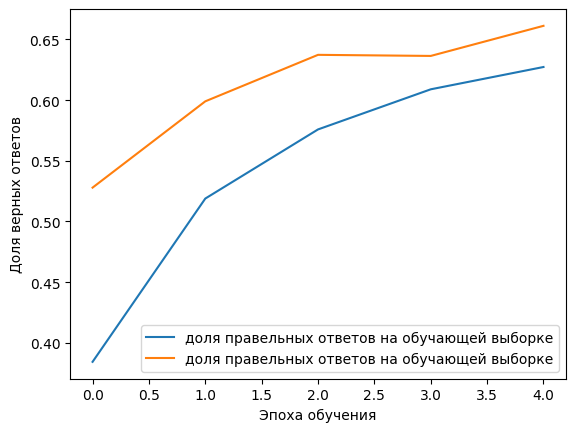

In [34]:
model_c = Sequential()

model_c.add(BatchNormalization(input_shape = (32, 32, 3)))
model_c.add(Conv2D(32, kernel_size=(3,3), activation= 'relu'))
model_c.add(Conv2D(32, kernel_size=(3,3), activation= 'relu'))
model_c.add(MaxPool2D(pool_size = (2,2)))
model_c.add(Dropout(0.25))
model_c.add(Flatten())
model_c.add(Dense(128, activation = 'relu'))
model_c.add(Dropout(0.5))
model_c.add(Dense(10, activation = 'softmax'))

model_c.compile(loss = tf.keras.losses.categorical_crossentropy, optimizer = 'Adam', metrics = ['accuracy'])

history = model_c.fit(X_train10, y_train10,
                      batch_size = 200,
                      epochs = 5,
                      validation_split = 0.2,
                      verbose = 1)
plt.plot(history.history['accuracy'],
         label = 'доля правельных ответов на обучающей выборке')

plt.plot(history.history['val_accuracy'],
         label = 'доля правельных ответов на обучающей выборке')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [35]:
MODEL_DIR = '/tmp/cifar10'
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print(export_path)

/tmp/cifar10/1


In [36]:
# сохраняем модель save_model
tf.keras.models.save_model(
    model_c, export_path, overwrite = True, include_optimizer = True, save_format = None,
    signatures = None,
    options = None
)

In [37]:
# сигнатура модели
!saved_model_cli show --dir {export_path} --all

2023-11-26 11:29:16.796524: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 11:29:16.796601: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 11:29:16.796648: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 11:29:17.948278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the follo

In [38]:
# программа распознавания для ч/б и цветных изображений
!echo "test" >>models.config

In [ ]:
# model.config
...
model_congig_list{
  config{
    name: 'mnist'
    base_path: '/temp/mnist/'
    model_platform: 'tensorflow'
  }
  config{
    name: 'cifar10'
    base_path: '/temp/cifar10/'
    model_platform:'tensorflow'
  }
}
...

In [39]:
# запуск сервера tensorflow
%%bash --bg
nohup tensorflow_model_server  \
  --rest_api_port=8511 \
  --allow_version_labels_for_unavaliable_models \
  --model_config_file=model.config \
  --model_config_file_pool_wait_seconds=60 >server2.log 2>&1

In [55]:
# программа для распознования изображений
def img_predict(img_list):
  headers = {"content-type" : "aplication/json"}

  for i in img_list:
    print(i.shape)

    if i.shape[2] == 1:
      x = i
      x = x.reshape(28,28,1)
      x = x /255.0
      data = json.dumps({"signature_name": "serving_default", "inputs":np.expand_dims(x, axis=0).tolist()})
      json_response = requests.post("http://localhost:8511/v1/models/mnist:predict", data = data, headers = headers)
      predictions = json_response.json()
      print('black_white prediction', predictions)

    else:
      x = i
      x = x.reshape(32, 32, 3)
      data = json.dumps({"signature_name": "serving_default", "inputs":np.expand_dims(x, axis=0).tolist()})
      json_response = requests.post("http://localhost:8511/v1/models/cifar10:predict", data = data, headers = headers)
      predictions = json_response.json()
      print('color_prediction', predictions)

    return

In [56]:
X_train[2].shape

(28, 28, 1)

In [57]:
X_train10[2].shape

(32, 32, 3)

In [58]:
img_pic_list = [X_train[2], X_train10[12], X_train[22], X_train10[222]]

In [59]:
img_predict(img_pic_list)

(28, 28, 1)


ConnectionError: ignored